In [1]:
import datetime as dt
import sys

import numpy as np
from scipy import stats
from scipy.interpolate import griddata

from mintpy.defaults.plot import *
from mintpy.objects import giantTimeseries, gnss, timeseries
from mintpy.utils import readfile, utils as ut

############################## beginning of insar_vs_gnss class ##############################
class wyd_insar_vs_gnss:
    def __init__(self, ts_file, geom_file, temp_coh_file, site_names, gnss_source='UNR',
                 gnss_dir='./GNSS', ref_site='GV01', start_date=None, end_date=None,
                 min_ref_date=None):
        self.insar_file = ts_file
        self.geom_file = geom_file
        self.temp_coh_file = temp_coh_file
        self.site_names = site_names
        self.gnss_source = gnss_source
        self.gnss_dir = gnss_dir
        self.ref_site = ref_site
        self.num_site = len(site_names)
        self.ds = {}
        self.start_date = start_date
        self.end_date = end_date
        self.min_ref_date = min_ref_date

    def open(self):
        atr = readfile.read_attribute(self.insar_file)
        k = atr['FILE_TYPE']
        if k == 'timeseries':
            ts_obj = timeseries(self.insar_file)
        elif k == 'giantTimeseries':
            ts_obj = giantTimeseries(self.insar_file)
        else:
            raise ValueError(f'Un-supported time-series file: {k}')
        ts_obj.open(print_msg=False)
        self.metadata = dict(ts_obj.metadata)
        self.num_date = ts_obj.numDate
        # remove time info from insar_datetime to be consistent with gnss_datetime
        self.insar_datetime = np.array([i.replace(hour=0, minute=0, second=0, microsecond=0)
                                        for i in ts_obj.times])

        # default start/end_date & min_ref_date
        dt_buffer = dt.timedelta(days=30)
        self.start_date = self.start_date if self.start_date else (ts_obj.times[0] - dt_buffer).strftime('%Y%m%d')
        self.end_date = self.end_date if self.end_date else (ts_obj.times[-1] + dt_buffer).strftime('%Y%m%d')
        self.min_ref_date = self.min_ref_date if self.min_ref_date else ts_obj.times[5].strftime('%Y%m%d')
        if self.min_ref_date not in ts_obj.dateList:
            msg = f'min_ref_date {self.min_ref_date} does NOT exist in InSAR file: {self.insar_file}'
            raise ValueError(msg)

        self.read_gnss()
        self.read_insar()
        #self.calculate_rmse()
        return

    def read_gnss(self):
        # define GNSS station object based on processing source
        GNSS = gnss.get_gnss_class(self.gnss_source)

        # read data for each GNSS site
        for sname in self.site_names:
            site = {}
            site['name'] = sname
            gnss_obj = GNSS(sname, data_dir=self.gnss_dir)
            gnss_obj.open(print_msg=False)
            site['lat'] = gnss_obj.site_lat
            site['lon'] = gnss_obj.site_lon

            dates, dis, dis_std = gnss_obj.get_los_displacement(
                self.geom_file,
                start_date=self.start_date,
                end_date=self.end_date,
                ref_site=self.ref_site,
                gnss_comp='enu2los',
            )[0:3]
            site['gnss_datetime'] = dates
            site['gnss_dis'] = dis
            site['gnss_std'] = dis_std

            site['reference_site'] = self.ref_site
            self.ds[sname] = site

            sys.stdout.write(f'\rreading GNSS {sname}')
            sys.stdout.flush()
        print()
        return

    def read_insar(self):
        # 2.1 prepare interpolation
        coord = ut.coordinate(self.metadata, lookup_file=self.geom_file)
        lats = [self.ds[k]['lat'] for k in self.ds.keys()]
        lons = [self.ds[k]['lon'] for k in self.ds.keys()]
        geo_box = (min(lons), max(lats), max(lons), min(lats))     #(W, N, E, S)
        pix_box = coord.bbox_geo2radar(geo_box)     #(400, 1450, 550, 1600)
        src_lat = readfile.read(self.geom_file, datasetName='latitude', box=pix_box)[0].reshape(-1,1)
        src_lon = readfile.read(self.geom_file, datasetName='longitude', box=pix_box)[0].reshape(-1,1)
        src_pts = np.hstack((src_lat, src_lon))

        dest_pts = np.zeros((self.num_site, 2))
        for i in range(self.num_site):
            site = self.ds[self.site_names[i]]
            dest_pts[i,:] = site['lat'], site['lon']

        # 2.2 interpolation - displacement / temporal coherence
        interp_method = 'linear'   #nearest, linear, cubic
        src_value, atr = readfile.read(self.insar_file, box=pix_box)
        src_value = src_value.reshape(self.num_date, -1)
        if atr['FILE_TYPE'] == 'giantTimeseries':
            src_value *= 0.001
        insar_dis = np.zeros((self.num_site, self.num_date))
        for i in range(self.num_date):
            insar_dis[:,i] = griddata(src_pts, src_value[i,:], dest_pts, method=interp_method)
            sys.stdout.write(('\rreading InSAR acquisition {}/{}'
                              ' with {} interpolation').format(i+1, self.num_date, interp_method))
            sys.stdout.flush()
        print()

        print('reading temporal coherence')
        src_value = readfile.read(self.temp_coh_file, box=pix_box)[0].flatten()
        temp_coh = griddata(src_pts, src_value, dest_pts, method=interp_method)

        # 2.3 write interpolation result
        # 使用np.where找到ref_site在site_names中的索引
        ref_site_index = np.where(self.site_names == self.ref_site)[0]
        if ref_site_index.size == 0:
            raise ValueError(f"{self.ref_site} not found in self.site_names")
        ref_site_index = ref_site_index[0]
        self.insar_dis_name = f'insar_dis_{interp_method}'
        insar_dis_ref = insar_dis[ref_site_index, :]
        for i in range(self.num_site):
            site = self.ds[self.site_names[i]]
            site['insar_datetime'] = self.insar_datetime
            # reference insar to the precise location in space
            site[self.insar_dis_name] = insar_dis[i, :] - insar_dis_ref
            site['temp_coh'] = temp_coh[i]

        # 2.4 reference insar and gnss to a common date
        print('reference insar and gnss to a common date')
        for i in range(self.num_site):
            site = self.ds[self.site_names[i]]
            gnss_date = site['gnss_datetime']
            insar_date = site['insar_datetime']

            # find common reference date
            ref_date = dt.datetime.strptime(self.min_ref_date, "%Y%m%d")
            ref_idx = insar_date.tolist().index(ref_date)
            while ref_idx < self.num_date:
                if insar_date[ref_idx] not in gnss_date:
                    ref_idx += 1
                else:
                    break
            if ref_idx == self.num_date:
                msg = f"InSAR and GNSS do not share ANY date for site: {site['name']}"
                raise RuntimeError(msg)
            comm_date = insar_date[ref_idx]

            # reference insar in time
            site[self.insar_dis_name] -= site[self.insar_dis_name][ref_idx]
            # reference gnss dis/std in time
            ref_idx_gnss = np.where(gnss_date == comm_date)[0][0]
            site['gnss_dis'] -= site['gnss_dis'][ref_idx_gnss]
            site['gnss_std'] = np.sqrt(site['gnss_std']**2 + site['gnss_std'][ref_idx_gnss]**2)
            site['gnss_std_mean'] = np.mean(site['gnss_std'])
        return


    def calculate_rmse(self):
        ## 3. calculate RMSE
        for i in range(self.num_site):
            site = self.ds[self.site_names[i]]
            gnss_date = site['gnss_datetime']
            insar_date = site['insar_datetime']
            comm_dates = np.array(sorted(list(set(gnss_date) & set(insar_date))))
            num_comm_date = len(comm_dates)

            # get displacement at common dates
            comm_dis_insar = np.zeros(num_comm_date, np.float32)
            comm_dis_gnss   = np.zeros(num_comm_date, np.float32)
            for j in range(num_comm_date):
                idx1 = np.where(gnss_date   == comm_dates[j])[0][0]
                idx2 = np.where(insar_date == comm_dates[j])[0][0]
                comm_dis_gnss[j]   = site['gnss_dis'][idx1]
                comm_dis_insar[j] = site[self.insar_dis_name][idx2]
            site['comm_dis_gnss'] = comm_dis_gnss
            site['comm_dis_insar'] = comm_dis_insar
            site['r_square'] = stats.linregress(comm_dis_gnss, comm_dis_insar)[2]
            site['dis_rmse'] = np.sqrt(np.sum(np.square(comm_dis_gnss - comm_dis_insar)) / (num_comm_date - 1))
            #print('site: {}, RMSE: {:.1f} cm'.format(self.site_names[i], dis_rmse*100.))


    def sort_by_velocity(ds):
        ## 4. calculate velocity to sort plotting order
        site_vel = {}
        site_names = sorted(list(ds.keys()))
        for sname in site_names:
            site = ds[sname]
            # design matrix
            yr_diff = np.array([i.year + (i.timetuple().tm_yday - 1) / 365.25 for i in site['gnss_datetime']])
            yr_diff -= yr_diff[0]
            A = np.ones([len(site['gnss_datetime']), 2], dtype=np.float32)
            A[:, 0] = yr_diff
            # LS estimation
            ts = np.array(site['gnss_dis'])
            ts -= ts[0]
            X = np.dot(np.linalg.pinv(A), ts)[0]
            site_vel[sname] = X

        site_names2plot = [i[0] for i in sorted(site_vel.items(), key=lambda kv: kv[1], reverse=True)]
        site_names2plot = [i for i in site_names2plot if site_vel[i] != 0]
        return site_names2plot

    def print_stats(ds):
        site_names = sorted(list(ds.keys()))
        for sname in site_names:
            site = ds[sname]
            print('{}, rmse: {:.1f} cm, r_square: {:.2f}, temp_coh: {:.2f}'.format(
                sname,
                site['dis_rmse']*100.,
                site['r_square'],
                site['temp_coh'],
            ))
        return

    def plot_one_site(ax, site, offset=0.):
        # GNSS
        ax.errorbar(site['gnss_datetime'],
                    site['gnss_dis']-offset,
                    yerr=site['gnss_std']*3.,
                    ms=marker_size*0.2, lw=0, alpha=1., fmt='-o',
                    elinewidth=edge_width*0.5, ecolor='C0',
                    capsize=marker_size*0.25, markeredgewidth=edge_width*0.5,
                    label='GNSS', zorder=1)
        # InSAR
        ecolor = 'gray' if site['temp_coh'] < 0.7 else 'C1'
        insar_dis_name = [i for i in site.keys() if i.startswith('insar_dis')][0]
        ax.scatter(site['insar_datetime'],
                   site[insar_dis_name]-offset,
                   s=5**2, label='InSAR',
                   facecolors='none', edgecolors=ecolor, linewidth=1., alpha=0.7, zorder=2)
        # Label
        ax.annotate('{:.1f} / {:.2f} / {:.2f}'.format(site['dis_rmse']*100., site['r_square'], site['temp_coh']),
                    xy=(1.03, site[insar_dis_name][-1] - offset - 0.02),
                    xycoords=ax.get_yaxis_transform(),  # y in data untis, x in axes fraction
                    color='k', fontsize=font_size)
        ax.annotate('{}'.format(site['name']),
                    xy=(0.05, site[insar_dis_name][0] - offset + 0.1),
                    xycoords=ax.get_yaxis_transform(),  # y in data untis, x in axes fraction
                    color='k', fontsize=font_size)
        return ax

In [2]:
import numpy as np
from matplotlib import pyplot as plt, ticker
from mintpy.utils import plot as pp
from mintpy.objects.insar_vs_gnss import insar_vs_gnss
from mintpy import view

In [8]:
ref_site = 'P606'
start_date = '20150327'
end_date = '20240408'

ts_file       = '../mintpy_no_ion_upsample/timeseries_SET_ERA5_demErr.h5'
geom_file     = '../mintpy_no_ion_upsample/inputs/geometryRadar.h5'
temp_coh_file = '../mintpy_no_ion_upsample/temporalCoherence.h5'

site_names = np.array(['P812','P595','P606','PEAR','TOWG'], dtype='<U10')

In [9]:
obj = wyd_insar_vs_gnss(ts_file, geom_file, temp_coh_file,site_names, gnss_source='UNR',gnss_dir='./GNSS',ref_site=ref_site,start_date=start_date, end_date=end_date)
obj.open()
ds = dict(obj.ds)

reading GNSS TOWG
reading InSAR acquisition 293/293 with linear interpolation
reading temporal coherence
reference insar and gnss to a common date


## GNSS和InSAR的时间相差不超过7天进行曲线拟合

In [23]:
import numpy as np
from datetime import datetime, timedelta
site=ds['P595']
##找gnss的点
comm_gnss_dates = []
for gnss_d in site['gnss_datetime']:
    for insar_d in site['insar_datetime']:
        if abs(insar_d - gnss_d) <= timedelta(days=7):
            comm_gnss_dates.append(gnss_d)
            break
comm_gnss_dates = np.array(sorted(comm_gnss_dates))
num_comm_gnss_date = len(comm_gnss_dates)
##找insar的点
comm_insar_dates = []
for insar_d in site['insar_datetime']:
    for gnss_d in site['gnss_datetime']:
        if abs(insar_d - gnss_d) <= timedelta(days=7):
            comm_insar_dates.append(insar_d)
            break
comm_insar_dates = np.array(sorted(comm_insar_dates))
num_comm_insar_date = len(comm_insar_dates)

##重新写形变量
comm_dis_insar = np.zeros(num_comm_insar_date, np.float32)
comm_dis_gnss   = np.zeros(num_comm_gnss_date, np.float32)
for i in range(num_comm_gnss_date):
    idx1= np.where(site['gnss_datetime'] == comm_gnss_dates[i])[0][0]
    comm_dis_gnss[i]  = site['gnss_dis'][idx1]
for j in range(num_comm_insar_date):
    idx2 = np.where(site['insar_datetime'] == comm_insar_dates[j])[0][0]
    comm_dis_insar[j] = site['insar_dis_linear'][idx2]
site['7day_dis_gnss'] = comm_dis_gnss
site['7day_dis_insar'] = comm_dis_insar

diff_vel 0.3301122047777296


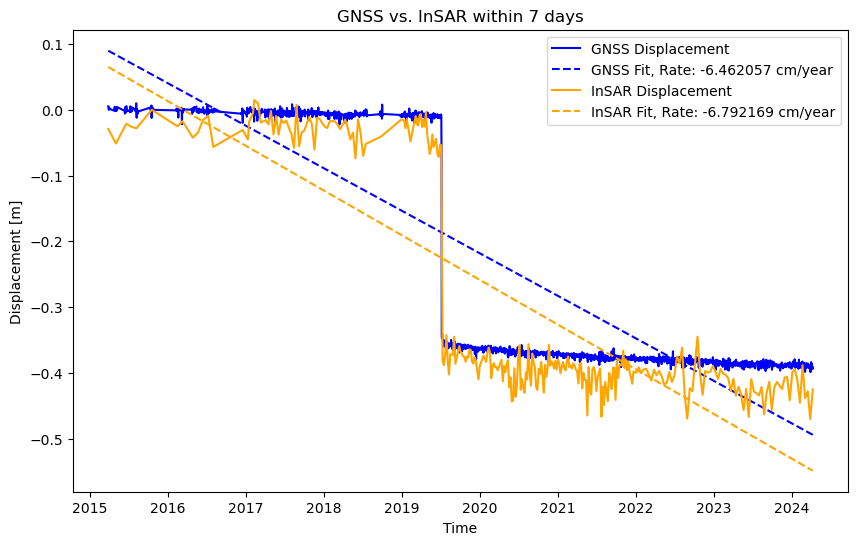

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 将日期转换为数值，以方便进行线性回归计算
gnss_dates_num = np.array([(date - datetime(1970, 1, 1)).total_seconds() for date in comm_gnss_dates])
insar_dates_num = np.array([(date - datetime(1970, 1, 1)).total_seconds() for date in comm_insar_dates])

# 一年的秒数
seconds_per_year = 365.25 * 24 * 3600

plt.figure(figsize=(10, 6))  # 宽10英寸，高6英寸
# 绘制GNSS时间序列
plt.plot(comm_gnss_dates, site['7day_dis_gnss'], color='blue', label='GNSS Displacement')
# 对GNSS数据进行线性回归拟合
gnss_slope, gnss_intercept = np.polyfit(gnss_dates_num, site['7day_dis_gnss'], 1)
# 转换速率单位为cm/year
gnss_slope_cm_year = gnss_slope * seconds_per_year * 100
gnss_fit = gnss_slope * gnss_dates_num + gnss_intercept
plt.plot(comm_gnss_dates, gnss_fit, linestyle='--', color='blue',
         label=f'GNSS Fit, Rate: {gnss_slope_cm_year:.6f} cm/year')

# 绘制InSAR时间序列
plt.plot(comm_insar_dates, site['7day_dis_insar'], color='orange', label='InSAR Displacement')
# 对InSAR数据进行线性回归拟合
insar_slope, insar_intercept = np.polyfit(insar_dates_num, site['7day_dis_insar'], 1)
# 转换速率单位为cm/year
insar_slope_cm_year = insar_slope * seconds_per_year * 100
insar_fit = insar_slope * insar_dates_num + insar_intercept
plt.plot(comm_insar_dates, insar_fit, linestyle='--', color='orange',
         label=f'InSAR Fit, Rate: {insar_slope_cm_year:.6f} cm/year')

# 计算速率差
diff_vel = abs(gnss_slope_cm_year - insar_slope_cm_year)
print('diff_vel',diff_vel)

# 设置图表标签
plt.xlabel('Time')
plt.ylabel('Displacement [m]')
plt.title('GNSS vs. InSAR within 7 days')

# 添加图例，包含速率差
plt.legend()

# 显示图表
plt.show()

diff_vel 0.5028356891212589


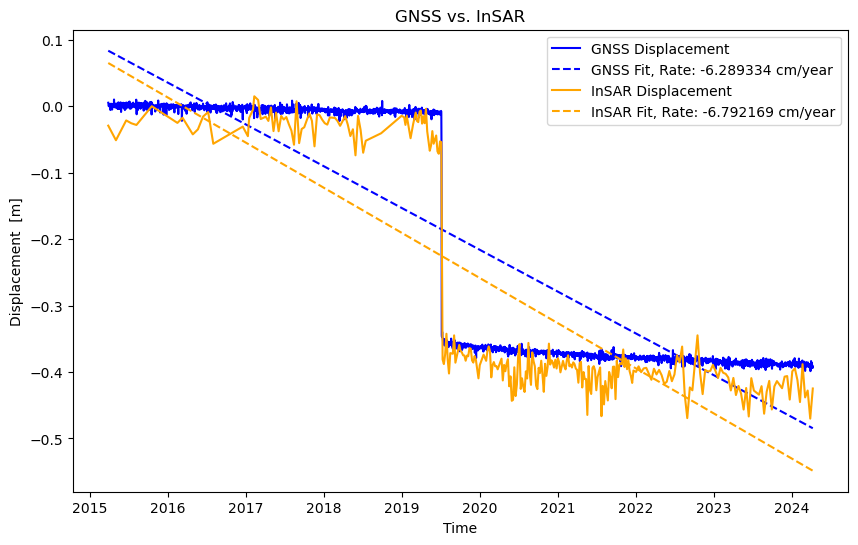

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 将GNSS日期转换为数值，以方便进行线性回归计算
gnss_dates_num = np.array([(date - datetime(1970, 1, 1)).total_seconds() for date in site['gnss_datetime']])
# 将InSAR日期转换为数值，以方便进行线性回归计算
insar_dates_num = np.array([(date - datetime(1970, 1, 1)).total_seconds() for date in site['insar_datetime']])

# 一年的秒数
seconds_per_year = 365.25 * 24 * 3600

plt.figure(figsize=(10, 6))  # 宽10英寸，高6英寸
# 绘制GNSS时间序列
plt.plot(site['gnss_datetime'], site['gnss_dis'], color='blue', label='GNSS Displacement')
# 对GNSS数据进行线性回归拟合
gnss_slope, gnss_intercept = np.polyfit(gnss_dates_num, site['gnss_dis'], 1)
# 转换速率单位为cm/year
gnss_slope_cm_year = gnss_slope * seconds_per_year * 100
gnss_fit = gnss_slope * gnss_dates_num + gnss_intercept
plt.plot(site['gnss_datetime'], gnss_fit, linestyle='--', color='blue',
         label=f'GNSS Fit, Rate: {gnss_slope_cm_year:.6f} cm/year')

# 绘制InSAR时间序列
plt.plot(site['insar_datetime'], site['insar_dis_linear'], color='orange', label='InSAR Displacement')
# 对InSAR数据进行线性回归拟合
insar_slope, insar_intercept = np.polyfit(insar_dates_num, site['insar_dis_linear'], 1)
# 转换速率单位为cm/year
insar_slope_cm_year = insar_slope * seconds_per_year * 100
insar_fit = insar_slope * insar_dates_num + insar_intercept
plt.plot(site['insar_datetime'], insar_fit, linestyle='--', color='orange',
         label=f'InSAR Fit, Rate: {insar_slope_cm_year:.6f} cm/year')

# 计算速率差
diff_vel = abs(gnss_slope_cm_year - insar_slope_cm_year)
print('diff_vel',diff_vel)

# 设置图表标签
plt.xlabel('Time')
plt.ylabel('Displacement  [m]')
plt.title('GNSS vs. InSAR')

# 添加图例
plt.legend()

# 显示图表
plt.show()